- fine tunning : 새로운 레이어를 구성해서 학습
- trainable technique으로 예측하는 부분만 재학습시킴
- pre-trained model: 그대로 가져오는 경우 
   - 데이터가 많으면 구조를 가져와서 처음부터 다시 학습하면 제일 좋음
- learning curve 확인 (적정 데이터양은 이미지와 모델의 복잡도에 따라 달라지기 때문)
- data augmentation : overfitting 막으나 accuracy 급격하게 늘어나지않음

<br>

- 데이터가 적을 때 : fully쓰면 과적합 위험 큼 -> global
- 많을 때 : fully connected

In [1]:
import tensorflow_datasets as tfds
import tensorflow as tf

C:\Users\Gyu\Anaconda3\envs\py37\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\Gyu\Anaconda3\envs\py37\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
C:\Users\Gyu\Anaconda3\envs\py37\lib\site-packages\numpy\.libs\libopenblas.TXA6YQSD3GCQQC22GEQ54J2UDCXDXHWN.gfortran-win_amd64.dll
  stacklevel=1)


In [8]:
(raw_train, raw_validation, raw_test), metadata = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

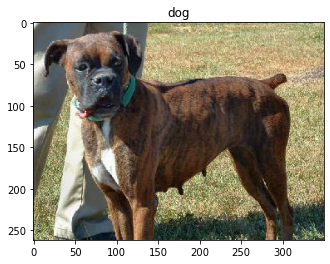

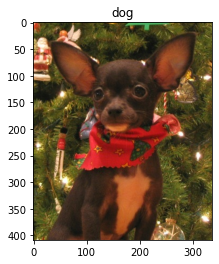

In [9]:
import matplotlib.pyplot as plt
get_label_name = metadata.features['label'].int2str

for image, label in raw_train.take(2):
    plt.figure()
    plt.imshow(image)
    plt.title(get_label_name(label))

tf.keras.layers.experimental.preprocessing.Resizing 등

요새는 잘 사용x

#### tf.data.dataset
- tensor로 직접 관리

#### tf.image
- tf.data.dataset으로 만듬 -> prefetch 등으로 최적의 학습환경 만듬
- 전체를 동시에 바꾸기 -> **map**
    - 함수 만들어야 (higher order)

In [10]:
IMG_SIZE = 160 

def format_example(image, label):
    image = tf.cast(image, tf.float32)
    image = (image/127.5) - 1
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return image, label

In [11]:
train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)

In [ ]:
tf.data.Dataset.from_tensors([[1,2],[3,4]])

In [7]:
tf.data.Dataset.from_tensor_slices([[1,2],[3,4]])

<TensorDataset shapes: (2, 2), types: tf.int32>

In [12]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

In [13]:
train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

In [14]:
for image_batch, label_batch in train_batches.take(1):
    pass

image_batch.shape

TensorShape([32, 160, 160, 3])

In [15]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

convolution feature extract 부분은 크기에 상관없음

## feature extract

In [16]:
base_model.trainable = False
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 161, 161, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

In [35]:
model = tf.keras.Sequential([
  base_model,
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(1)
])

In [36]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
flatten_4 (Flatten)          (None, 32000)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 32001     
Total params: 2,289,985
Trainable params: 32,001
Non-trainable params: 2,257,984
_________________________________________________________________


In [20]:
model2 = tf.keras.Sequential([
  base_model,
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(1)
])
model2.summary()
# 파라미터 더 적다
# dense가 더 잘 가능성이 높긴 함.

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


In [37]:
model.compile(optimizer='adam', metrics = ['acc'],
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True))

In [39]:
initial_epochs = 5
validation_steps=20

loss0,accuracy0 = model.evaluate(validation_batches, steps = validation_steps)
# 기본 모델

20/20 [==============================] - 6s 287ms/step - loss: 0.7723 - acc: 0.5891


In [40]:
history = model.fit(train_batches,
                    epochs=initial_epochs,
                    validation_data=validation_batches)

Epoch 1/5
582/582 [==============================] - 188s 324ms/step - loss: 0.1829 - acc: 0.9718 - val_loss: 0.1453 - val_acc: 0.9794
Epoch 2/5
582/582 [==============================] - 184s 317ms/step - loss: 0.0647 - acc: 0.9904 - val_loss: 0.1637 - val_acc: 0.9811
Epoch 3/5
582/582 [==============================] - 188s 323ms/step - loss: 0.0422 - acc: 0.9929 - val_loss: 0.2002 - val_acc: 0.9785
Epoch 4/5
582/582 [==============================] - 189s 325ms/step - loss: 0.0269 - acc: 0.9954 - val_loss: 0.1855 - val_acc: 0.9837
Epoch 5/5
582/582 [==============================] - 197s 339ms/step - loss: 0.0251 - acc: 0.9955 - val_loss: 0.2694 - val_acc: 0.9785


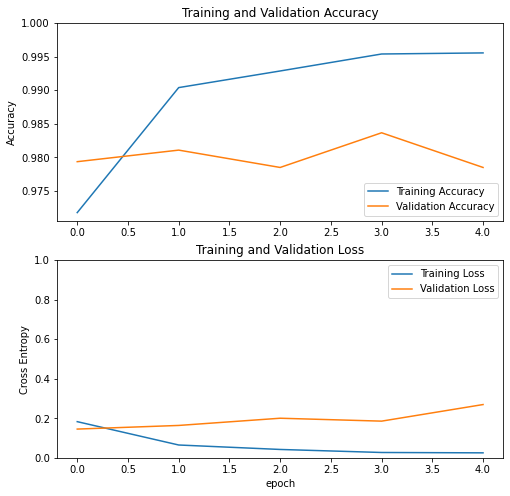

In [41]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

기존 모델에서 쓴 데이터보다 지금 쓰는 데이터가 더 적어서 validation이 요동 침
    - 여기서는 큰 변화는 아니긴 하지만 overfitting 가능성을 보여줌
    
https://www.tensorflow.org/tutorials/images/transfer_learning

- 위에서는 Global 사용 -> 성능도 좋고 학습 수도 적어 Global 자주 사용

<AxesSubplot:>

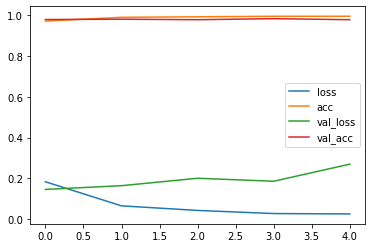

In [54]:
import pandas as pd
pd.DataFrame(history.history).plot.line()

https://papers.nips.cc/paper/5347-how-transferable-are-features-in-deep-neural-networks.pdf

Hands-On Transfer Learning with python
    - 4장 부분이 좋다고 함...


- one shot, two shot learning : 데이터 없을 때 학습하는 기법
    
## Incremental learning(transfer learning의 문제점)
- **데이터를 추가해서 새로운 category 학습 : Increment**
    - transfer : 모델의 지식을 가지고 새로운 것 분류
        - 모델로 라이터 1개 분류
    - incremental : 자신이 학습을 계속 하면서 지식을 키워가는 것
        - 모델로 1000개 + 라이터 1개 -> 1001개 분류
- keras에서는 학습한 것에 또 fit을 하면 이게 가능해서 헷갈릴 수 있음.
- 그렇지만 NN 특성상 불가능...
    - 새로운 것이 들어오면 기존에 배운 것에서 혼돈을 일으킴.
    - 이럴 때는 처음부터 학습시키는 게 나을 수 있음.
    
</br>

**transfer의 문제**

- 처음부터 학습을 하지 못함. -> 기존 모델을 학습시킨 데이터가 없기 때문

<br>

### knowledge distillation
- 선생님을 데려오는 개념
- 불순물이 많이 섞인 model로부터 필요한 능력만 가지게 하는 것
- incremental learning의 일부라 할 수 있음.

</br>

- 선생의 지식을 이용해 학생의 지식을 확장시킴
- 학생은 두 가지 예측
    - hard predict
    - soft : 선생의 기능을 받게 함.(선생의 soft predict)
- 보통 복잡한 모델을 선생으로 잡고 학생은 간략한 모델
- gan은 적대적이지만 얘는 서로 도와주는 것
- 그렇지만 학습이 안되는 경우가 많음... : catastrophe forgetting
    > **transfer가 훨씬 실용적임.**

</br>

#### gan 
- 적대적으로 학습

<br>

### 현재 학습상황 아는 기법
- tf.keras.backend

In [46]:
tf.keras.backend.get_value(model.optimizer.iterations)
# weight 등 하나씩 체크가능 (dir로 보기)

2910

### online learning
- online learning : 학습과 새로운 데이터 받는 것 동시에

<br>

## transfer learning more
https://www.tensorflow.org/guide/keras/transfer_learning


In [50]:
layer = tf.keras.layers.Dense(3)
layer.build((None, 4)) # input의 설정?
print("weights:", len(layer.weights))
print("trainable_weights:", len(layer.trainable_weights))

weights: 2
trainable_weights: 2


In [53]:
layer = tf.keras.layers.BatchNormalization()
layer.build((None, 4))
print("weights:", len(layer.weights))
print("trainable_weights:", len(layer.trainable_weights))

weights: 0
trainable_weights: 0


1. 기본 모델을 인스턴스화하고 사전 훈련 된 가중치를 여기에로드합니다.
2. trainable = False 를 설정하여 기본 모델의 모든 레이어를 고정합니다.
3. 기본 모델에서 하나 (또는 여러) 레이어의 출력 위에 새 모델을 만듭니다.
4. 새 데이터 세트에서 새 모델을 학습시킵니다.


모델에서 compile() 을 호출하는 것은 해당 모델의 동작을 "고정"하는 것을 의미합니다. 이는 것을 의미한다 trainable 때까지 모델이 컴파일 될 때 속성 값은, 그 모델의 수명에 걸쳐 보존되어야 compile 다시 호출한다. 따라서 trainable 값을 변경하는 경우 변경 사항을 고려하려면 모델에서 compile() 다시 호출해야합니다.

- BatchNormalization 에는 훈련 중에 업데이트되는 2 개의 훈련 불가능 가중치가 포함됩니다. 입력 값의 평균과 분산을 추적하는 변수입니다.
- bn_layer.trainable = False 를 설정하면 BatchNormalization 계층이 추론 모드에서 실행되고 평균 및 분산 통계를 업데이트하지 않습니다. 웨이트 트레이닝 가능성 및 추론 / 트레이닝 모드는 두 가지 직교 개념 이므로 일반적으로 다른 계층에는 해당되지 않습니다. 그러나 BatchNormalization 계층의 경우 두 가지가 연결되어 있습니다.
- 미세 조정을 수행하기 위해 BatchNormalization 레이어가 포함 된 모델을 BatchNormalization 하는 경우 기본 모델을 호출 할 때 training=False 를 전달하여 BatchNormalization 레이어를 추론 모드로 유지해야합니다. 그렇지 않으면 훈련 불가능한 가중치에 적용된 업데이트가 모델이 학습 한 내용을 갑자기 파괴합니다.

<br>

BatchNormalization은 train과 test할 때 다르게 한다.

---

An Empirical Investigation of Catastrophic Forgetting in Gradient-Based Neural Networks

- Catastrophic Forgetting : 기존 학습된 것이 성능이 안 좋아짐.
    - 항상 생기는 것은 아님 : NFL (논문에서 Emperical(경험적))
- 거의 죽어버린 기법이라 아래가 중요
- **Dropout(핵심)**
    - 복잡한 model은 주로 ensemble 모델임.
    - ensemble 하면 Catastrophic Forgetting이 덜 일어난다.
    
- BatchNormalization은 overfitting문제를 주로 해결 -> dropout과 같이 씀.